In [1]:
from dataclasses import dataclass
import itertools
import logging
import random
import math
import numpy as np
import json
import pickle
import time
import torch
import sys
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
from probe_utils import *
from plot_utils import *
from tqdm import tqdm

from omegaconf import OmegaConf
from pathlib import Path
from torch import nn, Tensor
from torch.nn import functional as F
from typing import List, Optional, Tuple
import os
# os.chdir("/data/your_name/birth")
from model import *
from two_hop_data import *

%load_ext autoreload
%autoreload 2

"""values that you need to change"""
DEVICE = "cuda:0"
PROJECT_PATH = "/data/your_name/twohop" # the path of your working directory
date = "2025-01-15" # the date of the model you want to plot
layer = 3 # the layer of the model you want to plot
head = 1 # the head of the model you want to plot
hopk = 2 # the hopk of the model you want to plot
steps = 10000 # the steps of the model you want to plot
run_path=f"pre-icml/L{layer}_hopk{hopk}_uniform_fine_seed42" # the run path of the model you want to plot


In [24]:
device = DEVICE
torch.cuda.set_device(device)
def compute_loss(y, pred, seqs_ans_pos_start, seqs_ans_pos_end, indices, type='cross_entropy'):
    y_start = torch.LongTensor(seqs_ans_pos_start).unsqueeze(-1)
    y_end = torch.LongTensor(seqs_ans_pos_end).unsqueeze(-1)
    # mask_pred = (indices >= y_pos).long().cuda()
    mask = ((indices >= y_start) & (indices < y_end)).long().cuda()
    mask_bias = -1 * ((indices < y_start) | (indices >= y_end)).long().cuda()
    # masked_pred = pred * mask_pred.unsqueeze(-1)
    # masked_x = x*mask
    masked_y = y*mask + mask_bias
    # loss = F.cross_entropy(masked_pred[:, :-1, :].flatten(0, 1), masked_x[:, 1:].flatten(0, 1), reduction='none')
    if type == 'cross_entropy':
        loss = F.cross_entropy(pred.flatten(0, 1), masked_y.flatten(0, 1), ignore_index=-1)
    elif type == '0-1':
        indiv_loss = pred[mask==1, :].argmax(-1) != masked_y[mask==1]
        indiv_loss = indiv_loss.float()
        loss = torch.mean(indiv_loss)
    return loss
def load_model(date, depth, layer, head, steps, compute_loss=True, run_path=None):
    if run_path is None:
        run_path = os.path.join(PROJECT_PATH, f"runs/{date}layer{layer}head{head}")
    else:
        run_path = os.path.join(PROJECT_PATH, "runs/", run_path)
    cfg = OmegaConf.load(f"{run_path}/configure.yaml")
    cfg.model_args.dim = 256
    cfg.model_args.n_heads = head
    cfg.model_args.n_layers = layer
    if getattr(cfg.data_args, "max_seq_len", None) == None:
        cfg.data_args.max_seq_len = cfg.data_args.seq_len

    ds = two_hop_format(cfg.data_args)
    cfg.model_args.vocab_size = len(ds.vocab)+len(ds.special_tokens)
    model = Transformer(cfg.model_args)
    model.cuda()
    state_path = f"{run_path}/state_{steps}.pt"
    state = torch.load(state_path, map_location=device)
    model.load_state_dict(state['model_state_dict'])

    seqs, seqs_ans_pos_start, seqs_ans_pos_end = next(iterate_batches(ds, num_workers=48, seed=42, batch_size=512, total_count=1))
    indices = torch.arange(cfg.data_args.max_seq_len).expand(cfg.data_args.batch_size, -1)

    x = torch.LongTensor(seqs).cuda()
    if compute_loss:
        pred = model(x)
        loss = compute_loss(x, pred, seqs_ans_pos_start, seqs_ans_pos_end, indices)
        print(loss.item())
    return cfg, model, seqs, seqs_ans_pos_start, seqs_ans_pos_end
def plot_attns(outputs_list, seq_idx, seq_start, seq_len, twoSum=None):
    numToChr = {}
    if twoSum:
        numToChr[twoSum[seq_idx]['target']['start'][0]] = 'Src'
        numToChr[twoSum[seq_idx]['target']['mid'][0]] = 'Brg'
        numToChr[twoSum[seq_idx]['target']['end'][0]] = 'End'
    else:
        numToChr = {num: num for num in seqs[seq_idx][seq_start:seq_len]}
    for layer_idx in range(layer):
        for head_idx in range(head):
            attns = outputs_list[layer_idx]['attn_weights'].detach().cpu().numpy()
            attns_plot = attns[seq_idx, head_idx, seq_start:seq_len, seq_start:seq_len]
            mask = 1 - np.tril(np.ones_like(attns_plot))
            # label_text = text_test
            print(f"Layer {layer_idx}, Head {head_idx}")
            fig, ax = plt.subplots()
            nums = seqs[seq_idx][seq_start:seq_len]
            labels = [numToChr.get(num, '') for num in nums]
            labels[0] = r'$\langle s \rangle$'
            labels[-1] = 'query'
            sns.heatmap(
                attns_plot, mask=mask,
                cmap="Blues", xticklabels=labels, yticklabels=labels,
                vmin=0, vmax=1, cbar=True, cbar_kws={"shrink": 1.0, "pad": 0.01, "aspect":50, "ticks": [0, 1]}
            )
            
            for i in range(len(attns_plot)):
                for j in range(i+1):
                    ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='black', lw=1))
                
            ax.set_ylim(len(attns_plot)+0.1, 0)
            ax.set_xlim(0, len(attns_plot)+0.1)
            plt.savefig(os.path.join("icml_figures"))

In [3]:

cfg, model, seqs, seqs_ans_pos_start, seqs_ans_pos_end = load_model(date, None, layer, 1, steps, compute_loss=False, run_path=run_path)
ds = multi_hop_format(cfg.data_args)

seqs, seqs_ans_pos_start, seqs_ans_pos_end, twoSum, oneSum = next(iterate_batches(ds, num_workers=48, seed=42, batch_size=512, total_count=1, withhops=True))
hook = forward_hook([], '')
pred, outputs_list = model.modified_forward_with_hook(torch.LongTensor(seqs)[:, :-1].cuda(), hook)
seq_idx = 1
seq_start = 0
seq_len = seqs_ans_pos_start[0] + 1
plot_attns(outputs_list, seq_idx, seq_start, seq_len, twoSum)

In [39]:
indices = torch.arange(cfg.data_args.max_seq_len).expand(cfg.data_args.batch_size, -1)
x = torch.LongTensor(seqs).cuda()
y = x[:, 1:]
x = x[:, :-1]

In [44]:
acc = []
acc_no_mlp = []
for steps in [400, 10000]:
    for skip_mlp in [True, False]:
        run_path=f"pre-icml/L{layer}_hopk{hopk}_uniform_fine_seed42"
        cfg, model, _, _, _ = load_model(date, None, layer, 1, steps, compute_loss=False, run_path=run_path)

        target_mlp_layers = [0, 1, 2] if skip_mlp else []
        hook = check_embed(target_layers=[0,1,2], target_heads=[], target_mlp_layers=target_mlp_layers)
        pred, outputs_list = model.modified_forward_with_hook(torch.LongTensor(seqs)[:, :-1].cuda(), hook)
        accuracy = 1-compute_loss(y, pred, seqs_ans_pos_start, seqs_ans_pos_end, indices, type='0-1').item()
        if skip_mlp:
            acc_no_mlp.append(accuracy)
        else:
            acc.append(accuracy)

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

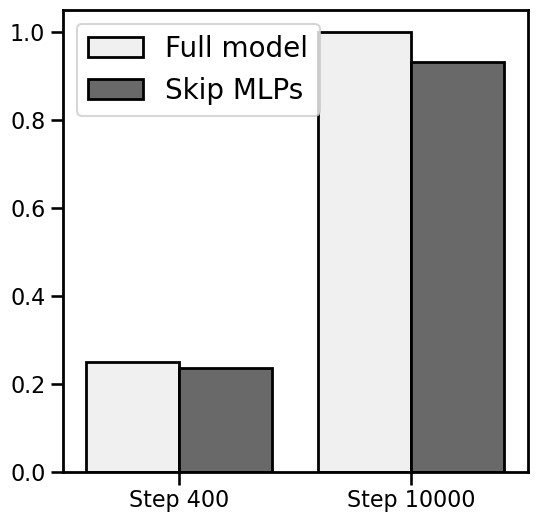

In [82]:
fontsize = 16
import pandas as pd

# with sns.axes_style("whitegrid"):
sns.set_context("talk")
groups = ['Step 400', 'Step 10000']
values_1 = list(map(lambda x: x[0], [acc, acc_no_mlp,]))
values_2 = list(map(lambda x: x[1], [acc, acc_no_mlp,]))

# Number of groups
n_groups = len(groups)
bar_width = 0.35
index = np.arange(n_groups)
fig, ax = plt.subplots(figsize=(6, 6))
ax.grid(linestyle='--')

df = pd.DataFrame({
    'Group': [g for g in groups for _ in range(2)],
    'Value': values_1 + values_2,
    'Category': ['Full model', 'Skip MLPs'] * len(groups)
})

# Create the Seaborn bar plot with error bars
custom_colors = ['#f0f0f0', "#696969",]
sns.barplot(x='Group', y='Value', hue='Category', data=df, palette=custom_colors, edgecolor='black', ax=ax,)
# plt.axhline(y=-math.log(1/66)-oracle_risk[2].item(), color='black', linestyle='--', label='random guess', lw=2)
bars = ax.patches
for bar in bars:
    bar.set_linewidth(2)
ax.grid(False, axis='y')


# Keep x-ticks non-rotated

plt.xticks(rotation=0)
ax.set_xlabel('')
ax.set_ylabel('', fontsize=fontsize)
# ax.set_xticks([1, 4, 6], )
# ax.set_xticks(fontsize=fontsize)
# ax.set_yticklabels(fontsize=fontsize)
ax.legend(fontsize=20)
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Set the linewidth (e.g., 2)
# ax.set_xlabel('')
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)